# Motional state system
Here, we want to show how a system with motional states can be simulated with AtomCalc. There are no motional state specific modules in the package. This is just an additional example of what can be done. \
We simulate a two-level system where we add one motional state to each level. \
We assume a harmonic potential that leads to the splitting of the motional states and describe the transitions with Franck-Condon coefficients. \
For all the background theory see my master thesis. \
This tutorial does not use realistic values. It rather is supposed to be a step by step guide of how a simulation with motional states can be done.

In [2]:
from atomcalc import Level, Laser, Decay, System, plot_pulse
import numpy as np
import scipy
from scipy import constants
import math

For the calculation of the Franck-Condon coefficients we define a few functions. \
`make_Hr` returns the Hermite polynomials that are needed for the calculation of the harmonic wavefunctions. \
`get_psi` calculates those wavefunctions. \
`FC_coefficient` calculates the Franck-Condon coefficient for a transition between sublevel `v1` of the cluster with trap (angular) frequency `omega1` and the sublevel `v2` of the cluster with trap (angular) frequency `omega2`. \
`m` is the mass of the atom and `k` the wavevector of the laser that couples the two sublevels (if there is no laser `k` is zero).

In [3]:
def make_Hr(max_v):
    """Return a list of np.poly1d objects representing Hermite polynomials."""
    Hr = [None] * (max_v + 1)
    Hr[0] = np.poly1d([1.,])
    Hr[1] = np.poly1d([2., 0.])
    for v in range(2, max_v+1):
        Hr[v] = Hr[1]*Hr[v-1] - 2*(v-1)*Hr[v-2]
    return Hr

def get_psi(v, m, omega, x):
    """Return the harmonic oscillator wavefunction for level v."""
    Hr = make_Hr(v+1)
    factor = np.sqrt(m*omega/scipy.constants.hbar)
    N = lambda v: (m*omega/(np.pi*scipy.constants.hbar))**(1/4)/np.sqrt(2**v*math.factorial(v))
    return N(v)*Hr[v](factor*x)*np.exp(-factor**2*x*x/2)

def FC_coefficient(m, v1, v2, omega1, omega2, k, x_list):
    """Calculate the Franck-Condon coefficient between sublevels v1 and v2."""
    return np.abs(np.trapz(get_psi(v1, m, omega1, x_list)*np.exp(1j*k*x_list)*get_psi(v2, m, omega2, x_list), x_list))

Next, let us define the trap frequencies, the mass of the atom, and the motional levels:

In [4]:
omega_1 = 1 # as angular frequency
omega_2 = 1.5
m = 1e-25 # in kg

# define level objects according to the energy separation of the quantum harmonic oscillator
level1_1 = Level(0 + 1/2*omega_1) # first sublevel of level 1
level1_2 = Level(0 + 3/2*omega_1) # second sublevel of level 1
level2_1 = Level(100 + 1/2*omega_2)
level2_2 = Level(100 + 3/2*omega_2)

With that we can calculate the Franck-Condon coefficients:

In [5]:
# Define laser properties
frequency_of_the_laser = (level2_1.energy - level1_1.energy) # angular frequency of the laser without detuning
Delta = 5 # detuning of the laser defined as angular frequency
Omega = 100 # Rabi frequency of the laser as angular frequency
k = (frequency_of_the_laser + Delta)/scipy.constants.c # wavevector of the laser

# calculate Franck-Condon coefficients
x_list = np.linspace(-1.2e-4,1.2e-4,200000) # define the interval to calculate the definite integral
FC11_21 = FC_coefficient(m, 0, 0, omega_1, omega_2, k, x_list) # between level1_1 and level2_1
FC11_22 = FC_coefficient(m, 0, 1, omega_1, omega_2, k, x_list) # between level1_1 and level2_2
FC12_21 = FC_coefficient(m, 1, 0, omega_1, omega_2, k, x_list) # between level1_2 and level2_1
FC12_22 = FC_coefficient(m, 1, 1, omega_1, omega_2, k, x_list) # between level1_2 and level2_2

The decay channels depend on the Franck-Condon coefficients. Here, every decay rate without the consideration of Franck-Condon coefficients is (arbitrarily) chosen to be one.

In [6]:
decay = Decay([1*FC11_21**2, 1*FC11_22**2, 1*FC12_21**2, 1*FC12_22**2],\
              [[level2_1,level1_1],[level2_2,level1_1],[level2_1,level1_2],[level2_2,level1_2]])

The next code block is just an insertion to visualize the wavefunctions and see that the borders of the definite integral make sense. Two wavefunctions are plotted inside the given borders. \
Additionally, the Franck-Condon coefficients are printed.

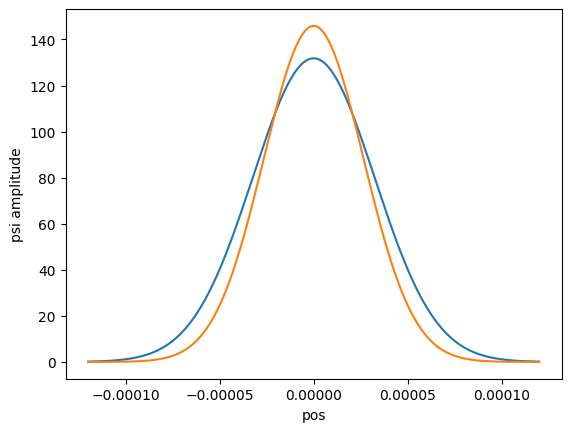

0.9898463956837853
7.818578997749391e-12
6.383843019374053e-12
0.9698472624862684


In [7]:
import matplotlib
import matplotlib.pylab as plt

fig, ax = plt.subplots()
x_list = np.linspace(-1.2e-4,1.2e-4,200000)
ax.plot(x_list, get_psi(0, 1e-25, omega_1, x_list)) #/41341373
ax.plot(x_list, get_psi(0, 1e-25, omega_2, x_list))
ax.set_xlabel('pos')
ax.set_ylabel('psi amplitude')
plt.show(fig)

print(FC11_21)
print(FC11_22)
print(FC12_21)
print(FC12_22)

Although there is just one laser, we need to define a laser object for every possible transition, where the `couple` argument is different. \
The Rabi frequency of each transition is influenced by the corresponding Franck-Condon factor. \
Also, the detunings must be chosen so that every laser has exactly the same frequency (because they all represent the same laser, just for different transitions). 

In [8]:
laser11_21 = Laser(Omega*FC11_21, Delta, [level1_1,level2_1])
laser11_22 = Laser(Omega*FC11_22, Delta - omega_2, [level1_1,level2_2])
laser12_21 = Laser(Omega*FC12_21, Delta + omega_1, [level1_2,level2_1])
laser12_22 = Laser(Omega*FC12_22, Delta + omega_1 - omega_2, [level1_2,level2_2])

print(laser11_21.frequency)
print(laser11_22.frequency)
print(laser12_21.frequency)
print(laser12_22.frequency)
print(frequency_of_the_laser + Delta)

105.25
105.25
105.25
105.25
105.25


Now we are ready to define the system object and draw the system sketch.

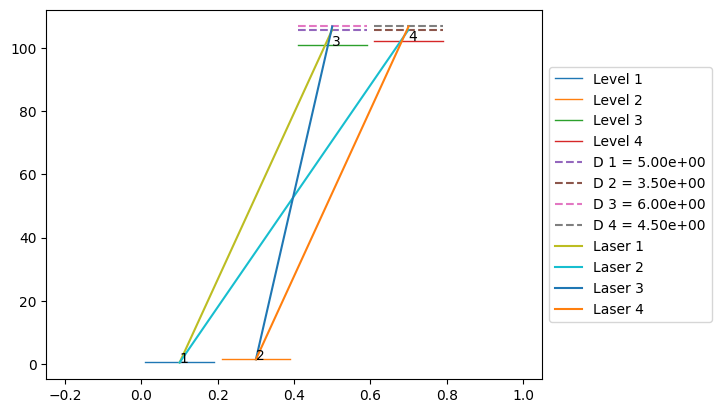

In [9]:
# define system (sort levels by energy in ascending order.)
system = System([level1_1,level1_2,level2_1,level2_2],\
                 [laser11_21,laser11_22,laser12_21,laser12_22], decay)

# draw the system in matplotlib
system.draw()

Now we can simulate the system. We can choose the starting population with the `initial_state_index_list`. We choose [0.6,0.4,0,0] which means 60% are in the first level, 40% are in the second level, and 0% are in the third and forth level at the start of the simulation.

Hamiltonian in the rotating frame: Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-5.00000000e-01  0.00000000e+00  4.94923198e+01  3.90928950e-10]
 [ 0.00000000e+00 -1.50000000e+00  3.19192151e-10  4.84923631e+01]
 [ 4.94923198e+01  3.19192151e-10  4.50000000e+00  0.00000000e+00]
 [ 3.90928950e-10  4.84923631e+01  0.00000000e+00  3.00000000e+00]]


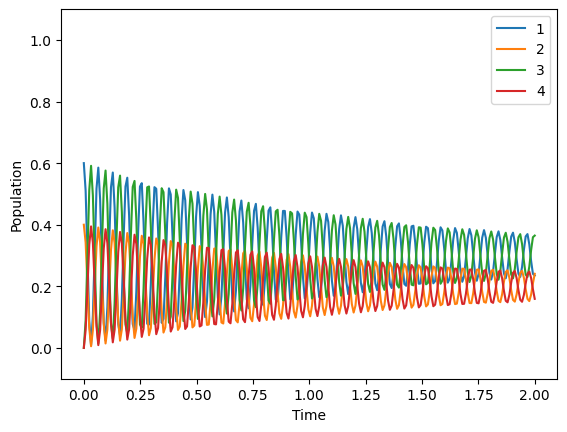

Maximum population of level 3:


0.5912821470183767

In [10]:
# simulate the system
system.simulate([0.6,0.4,0,0], 2, 2)